In [1]:
#TO DOs
#Date formatting in charts
# maybe add chart with fx.close, fx.close times slippage for v3, curve v2 twoPool, curve v2 three Pool


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fx = pd.read_csv('CHFEUR=short.csv')
fx['Date'] = pd.to_datetime(fx['Date'])

sx = pd.read_csv('CHFSGD=short.csv')
sx['Date'] = pd.to_datetime(fx['Date'])

#fx.Close[0]

Text(0, 0.5, 'Slippage')

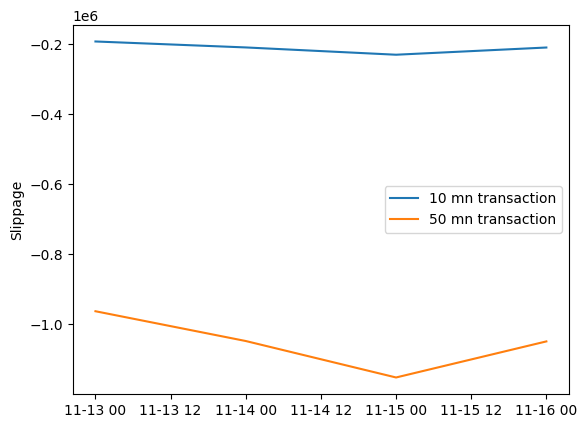

In [17]:
#Curve v2, 3-token pool 

def delta_x_3pool_newtohRaphson(x0, y0, z0, delta_y, A, gamma, D):
    """
    Calculating delta_x for buying delta_y using netwon-raphon method, x0, y0, z0 are token reserves in the pool, 
    A, gamma, D - parameters of the pool
    """
    return (42)
    
def slippage_3token_curve_v2(S_t, S_0, P_t, P_0, delta_y, N_0, A, gamma):
    """
    Calculating slippage at Curve v2 in 3 token pool, based on the spot exchange rates S_t between X-Y and P_t between X-Z
    """
    x0 = N_0 #initial reservers of CHF
    y0 = N_0 * S_t #initial reservers of EUR
    z0 = N_0 * P_t #initial reservers of SGD
    D = 3 * N_0 * (S_t * P_t) ** (1/3)

    delta_x = delta_x_3pool_newtohRaphson(x0, y0, z0, delta_y, A, gamma, D)
    tradePrice =  delta_y / delta_x
    slippage = 1 - tradePrice / S_t
    #print(slippage)
    return (slippage)


A = 50
gamma = 50000
S_0 = fx.Close[0] #exchange rate CHFEUR
P_0 = sx.Close[0] #exchange rate CHFSGD
N_0 = 100_000_000 #reserve pool of CHF 
delta_y1 = 10_000_000 # a trader buy this amount of EUR
delta_y2 = 50_000_000

v_slippage_y1=slippage_3token_curve_v2(S_t=fx.Close.to_numpy(),S_0=S_0, P_t=sx.Close.to_numpy(), P_0=P_0, delta_y=delta_y1,N_0=N_0, A=A, gamma=gamma)
v_slippage_y2=slippage_3token_curve_v2(S_t=fx.Close.to_numpy(),S_0=S_0, P_t=sx.Close.to_numpy(), P_0=P_0, delta_y=delta_y2,N_0=N_0, A=A, gamma=gamma)

plt.plot(fx.Date, v_slippage_y1, label="10 mn transaction")
plt.plot(fx.Date, v_slippage_y2, label="50 mn transaction")
plt.legend(loc="center right")
plt.ylabel("Slippage")


In [ ]:
#This codes comes from Curve smart contract

def newton_y(ANN: int, gamma: int, x: int[N_COINS], D: int, i: int) -> int:
    """
    Calculating x[i] given other balances x[0..N_COINS-1] and invariant D
    ANN = A * N**N
    """
    # Safety checks
    assert ANN > MIN_A - 1 and ANN < MAX_A + 1  # dev: unsafe values A
    assert gamma > MIN_GAMMA - 1 and gamma < MAX_GAMMA + 1  # dev: unsafe values gamma
    assert D > 10**17 - 1 and D < 10**15 * 10**18 + 1 # dev: unsafe values D
    for k in range(3):
        if k != i:
            frac: int = x[k] * 10**18 / D
            assert (frac > 10**16 - 1) and (frac < 10**20 + 1)  # dev: unsafe values x[i]

    y: int = D / N_COINS
    K0_i: int = 10**18
    S_i: int = 0

    x_sorted: int[N_COINS] = x
    x_sorted[i] = 0
    x_sorted = self.sort(x_sorted)  # From high to low

    convergence_limit: int = max(max(x_sorted[0] / 10**14, D / 10**14), 100)
    for j in range(2, N_COINS+1):
        _x: int = x_sorted[N_COINS-j]
        y = y * D / (_x * N_COINS)  # Small _x first
        S_i += _x
    for j in range(N_COINS-1):
        K0_i = K0_i * x_sorted[j] * N_COINS / D  # Large _x first

    for j in range(255):
        y_prev: int = y

        K0: int = K0_i * y * N_COINS / D
        S: int = S_i + y

        _g1k0: int = gamma + 10**18
        if _g1k0 > K0:
            _g1k0 = _g1k0 - K0 + 1
        else:
            _g1k0 = K0 - _g1k0 + 1

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1: int = 10**18 * D / gamma * _g1k0 / gamma * _g1k0 * A_MULTIPLIER / ANN

        # 2*K0 / _g1k0
        mul2: int = 10**18 + (2 * 10**18) * K0 / _g1k0

        yfprime: int = 10**18 * y + S * mul2 + mul1
        _dyfprime: int = D * mul2
        if yfprime < _dyfprime:
            y = y_prev / 2
            continue
        else:
            yfprime -= _dyfprime
        fprime: int = yfprime / y

        # y -= f / f_prime;  y = (y * fprime - f) / fprime
        # y = (yfprime + 10**18 * D - 10**18 * S) // fprime + mul1 // fprime * (10**18 - K0) // K0
        y_minus: int = mul1 / fprime
        y_plus: int = (yfprime + 10**18 * D) / fprime + y_minus * 10**18 / K0
        y_minus += 10**18 * S / fprime

        if y_plus < y_minus:
            y = y_prev / 2
        else:
            y = y_plus - y_minus

        diff: int = 0
        if y > y_prev:
            diff = y - y_prev
        else:
            diff = y_prev - y
        if diff < max(convergence_limit, y / 10**14):
            frac: int = y * 10**18 / D
            assert (frac > 10**16 - 1) and (frac < 10**20 + 1)  # dev: unsafe value for y
            return y

    raise "Did not converge"



In [22]:
#This codes comes from Curve smart contract but was modified by KG

N_COINS: int = 2  # <- change
A_MULTIPLIER: int= 10000

MIN_GAMMA: int = 10**10
MAX_GAMMA: int = 5 * 10**16

MIN_A: int = N_COINS**N_COINS * A_MULTIPLIER / 100
MAX_A: int = N_COINS**N_COINS * A_MULTIPLIER * 1000

def sort(A0: [int]) -> [int]:
    """
    Insertion sort from high to low
    """
    A: int[N_COINS] = A0
    for i in range(1, N_COINS):
        x: int = A[i]
        cur: int = i
        for j in range(N_COINS):
            y: int = A[cur-1]
            if y > x:
                break
            A[cur] = y
            cur -= 1
            if cur == 0:
                break
        A[cur] = x
    return A


def newton_y(ANN: int, gamma: int, x: [int], D: int, i: int) -> int:
    """
    Calculating x[i] given other balances x[0..N_COINS-1] and invariant D
    ANN = A * N**N
    """
    # Safety checks
    assert ANN > MIN_A - 1 and ANN < MAX_A + 1, "dev: unsafe values A, "
    assert gamma > MIN_GAMMA - 1 and gamma < MAX_GAMMA + 1, "dev: unsafe values gamma, "
    #print(D)
    assert D > 10**17 - 1 and D < 10**15 * 10**18 + 1, "dev: unsafe values D, "
    for k in range(N_COINS):
        if k != i:
            frac: int = x[k] * 10**18 / D
            #print(x[k])
            assert (frac > 10**16 - 1) and (frac < 10**20 + 1)  # dev: unsafe values x[i]

    y: int = D / N_COINS
    K0_i: int = 10**18
    S_i: int = 0

    x_sorted: int[N_COINS] = x
    x_sorted[i] = 0
    #x_sorted = sort(x_sorted)  # From high to low
    x_sorted[0] = x[1]
    x_sorted[1] = 0

    #print("hello1")
    #print(x_sorted[0])

    convergence_limit: int = max(max(x_sorted[0] / 10**14, D / 10**14), 100)
    for j in range(2, N_COINS+1):
        _x: int = x_sorted[N_COINS-j]
        y = y * D / (_x * N_COINS)  # Small _x first
        S_i += _x
    for j in range(N_COINS-1):
        K0_i = K0_i * x_sorted[j] * N_COINS / D  # Large _x first

    for j in range(255):
        y_prev: int = y

        K0: int = K0_i * y * N_COINS / D
        S: int = S_i + y

        _g1k0: int = gamma + 10**18
        if _g1k0 > K0:
            _g1k0 = _g1k0 - K0 + 1
        else:
            _g1k0 = K0 - _g1k0 + 1

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1: int = 10**18 * D / gamma * _g1k0 / gamma * _g1k0 * A_MULTIPLIER / ANN

        # 2*K0 / _g1k0
        mul2: int = 10**18 + (2 * 10**18) * K0 / _g1k0

        yfprime: int = 10**18 * y + S * mul2 + mul1
        _dyfprime: int = D * mul2
        if yfprime < _dyfprime:
            y = y_prev / 2
            continue
        else:
            yfprime -= _dyfprime
        fprime: int = yfprime / y

        # y -= f / f_prime;  y = (y * fprime - f) / fprime
        # y = (yfprime + 10**18 * D - 10**18 * S) // fprime + mul1 // fprime * (10**18 - K0) // K0
        y_minus: int = mul1 / fprime
        y_plus: int = (yfprime + 10**18 * D) / fprime + y_minus * 10**18 / K0
        y_minus += 10**18 * S / fprime

        if y_plus < y_minus:
            y = y_prev / 2
        else:
            y = y_plus - y_minus

        diff: int = 0
        if y > y_prev:
            diff = y - y_prev
        else:
            diff = y_prev - y
        if diff < max(convergence_limit, y / 10**14):
            frac: int = y * 10**18 / D
            assert (frac > 10**16 - 1) and (frac < 10**20 + 1)  # dev: unsafe value for y
            return y
    #print("hello3")
    raise "Did not converge"



In [36]:
def _geometric_mean(unsorted_x: [int], sort: bool = True) -> int:
    """
    (x[0] * x[1] * ...) ** (1/N)
    """
    x: [int] = unsorted_x
    if sort:
        x = sort(x)
    D: uint256 = x[0]
    diff: uint256 = 0
    for i in range(255):
        D_prev: uint256 = D
        tmp: uint256 = 10**18
        for _x in x:
            tmp = tmp * _x / D
        D = D * ((N_COINS - 1) * 10**18 + tmp) / (N_COINS * 10**18)
        if D > D_prev:
            diff = D - D_prev
        else:
            diff = D_prev - D
        if diff <= 1 or diff * 10**18 < D:
            return D
    raise "Did not converge"


def newton_D(ANN: int, gamma: int, x_unsorted: [int]) -> int:
    """
    Finding the invariant using Newton method.
    ANN is higher by the factor A_MULTIPLIER
    ANN is already A * N**N

    Currently uses 60k gas
    """
    # Safety checks
    assert ANN > MIN_A - 1 and ANN < MAX_A + 1  # dev: unsafe values A
    assert gamma > MIN_GAMMA - 1 and gamma < MAX_GAMMA + 1  # dev: unsafe values gamma

    # Initial value of invariant D is that for constant-product invariant
    x: [int] = sort(x_unsorted)

    assert x[0] > 10**9 - 1 and x[0] < 10**15 * 10**18 + 1  # dev: unsafe values x[0]
    for i in range(1, N_COINS):
        frac: uint256 = x[i] * 10**18 / x[0]
        assert frac > 10**11-1  # dev: unsafe values x[i]

    D: int = N_COINS * _geometric_mean(x, False)
    S: int = 0
    for x_i in x:
        S += x_i

    for i in range(255):
        D_prev: int = D

        K0: int = 10**18
        for _x in x:
            K0 = K0 * _x * N_COINS / D

        _g1k0: int = gamma + 10**18
        if _g1k0 > K0:
            _g1k0 = _g1k0 - K0 + 1
        else:
            _g1k0 = K0 - _g1k0 + 1

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1: int = 10**18 * D / gamma * _g1k0 / gamma * _g1k0 * A_MULTIPLIER / ANN

        # 2*N*K0 / _g1k0
        mul2: int = (2 * 10**18) * N_COINS * K0 / _g1k0

        neg_fprime: int = (S + S * mul2 / 10**18) + mul1 * N_COINS / K0 - mul2 * D / 10**18

        # D -= f / fprime
        D_plus: int = D * (neg_fprime + S) / neg_fprime
        D_minus: int = D*D / neg_fprime
        if 10**18 > K0:
            D_minus += D * (mul1 / neg_fprime) / 10**18 * (10**18 - K0) / K0
        else:
            D_minus -= D * (mul1 / neg_fprime) / 10**18 * (K0 - 10**18) / K0

        if D_plus > D_minus:
            D = D_plus - D_minus
        else:
            D = (D_minus - D_plus) / 2

        diff: int = 0
        if D > D_prev:
            diff = D - D_prev
        else:
            diff = D_prev - D
        if diff * 10**14 < max(10**16, D):  # Could reduce precision for gas efficiency here
            # Test that we are safe with the next newton_y
            for _x in x:
                frac: int = _x * 10**18 / D
                assert (frac > 10**16 - 1) and (frac < 10**20 + 1)  # dev: unsafe values x[i]
            return D

    raise "Did not converge"

0
D= 2.2244001438590135e+26
nD= 2.2244007090198443e+26
x0= 100000000000000000000000000
x1= 1.000008084237764e+26
dx= 8.084237763986944e+20
8.084237763986944e+20
1
D= 2.132228880772419e+26
nD= 2.1322292647196476e+26
x0= 100000000000000000000000000
x1= 1.0000087982810638e+26
dx= 8.798281063747572e+20
8.798281063747572e+20
2
D= 2.0335977970090348e+26
nD= 2.033597941886215e+26
x0= 100000000000000000000000000
x1= 1.0000096724538938e+26
dx= 9.672453893774954e+20
9.672453893774954e+20
3
D= 2.1311030007955975e+26
nD= 2.1311033823831344e+26
x0= 100000000000000000000000000
x1= 1.000008807580109e+26
dx= 8.807580108950654e+20
8.807580108950654e+20
hello
[1.23762376 1.13765643 1.03412616 1.13636364]
[1.236989 1.1366   1.03388  1.1354  ]


Text(0, 0.5, 'Slippage')

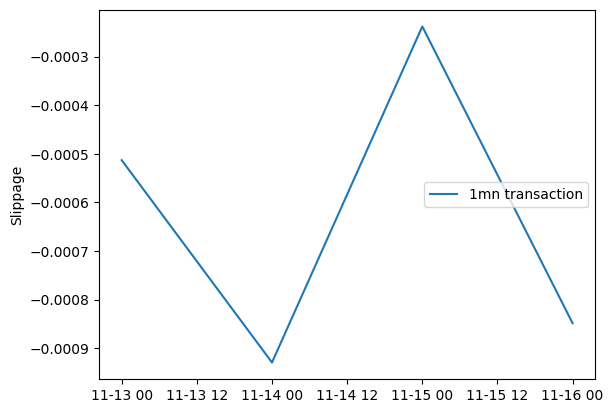

In [81]:
#Curve v2, 2-token pool
N_COINS = 2
ADJ_C = 10**18

def delta_x_newtohRaphson(x0:int, y0:int , delta_y:int, A, gamma, D):
    """
    Calculating delta_x for buying delta_y using netwon-raphon method, x0 and y0 are token reserves in the pool, 
    A, gamma, D - parameters of the Curve v2 pool with 2 tokens
    """
    if A == 0 : # When A=0 the formula simplifies to Uniswap v2
        k = ((D/2)**2)
        y1 = y0 - delta_y #a trader buys delta_y so the reservers are getting smaller
        x1 = k / y1 
        delta_x = x1 - x0 
        delta_x /= ADJ_C
        return (delta_x)
    
    ANN = A * N_COINS ** N_COINS
    ANN *= A_MULTIPLIER #this is an assumption of the code of Curve v2
    i = 0 #the firs token's reserver are unknows

    days = D.size
    delta_x = np.zeros(days, dtype=np.uint64)
    for j in range(days):
        print(j)

        xx = [x0, y0[j]]
        nD = newton_D(ANN, gamma, xx)

        print("D=",D[j])
        print("nD=",nD)

        x = [x0, y0[j]-delta_y]
        x1:int = newton_y(ANN, gamma, x, nD, i)

        #x1:int = newton_y(ANN, gamma, x, D[j], i)
        print("x0=",x0)
        print("x1=",x1)
        
        dx:int = x1 - x0
        print("dx=",dx)
        print(dx)
        delta_x[j] = dx / ADJ_C
    return (delta_x)
    
def slippage_2token_curve_v2(S_t, S_0, delta_y, N_0, A, gamma):
    """
    Calculating slippage at Curve v2 in 2 token pool, based on the spot exchange rates S_t 
    """

    N_0 *= ADJ_C #some magic for compatiablity newthon method in Curve smart contract
    delta_y_adj = delta_y * ADJ_C    #some magic for compatiablity newthon method in Curve smart contract

    x0 = N_0 #initial reservers of CHF
    y0 = N_0 * S_t #initial reservers of EUR
    D = 2 * N_0 * (S_t) ** 0.5 
    #print(D)
    #D *= 10**18
    print("hello1")
    delta_x = delta_x_newtohRaphson(x0, y0, delta_y_adj, A, gamma, D)
    print("hello2")
    tradePrice =  delta_y / delta_x
    print(tradePrice)
    print(S_t)
    slippage = 1 - tradePrice / S_t
    return (slippage)


A = 0.05
gamma = 0.000000011 * ADJ_C
S_0 = fx.Close[0]
N_0 = 100_000_000 #reserve pool of CHF 
delta_y1 = 1_000 # a trader buy this amount of EUR
delta_y2 = 5_000_000


v_slippage_y1=slippage_2token_curve_v2(S_t=fx.Close.to_numpy(),S_0=S_0,delta_y=delta_y1,N_0=N_0, A=A, gamma=gamma)
#v_slippage_y2=slippage_2token_curve_v2(S_t=fx.Close.to_numpy(),S_0=S_0,delta_y=delta_y2,N_0=N_0, A=A, gamma=gamma)

plt.plot(fx.Date, v_slippage_y1, label="1mn transaction")
#plt.plot(fx.Date, v_slippage_y2, label="5mn transaction")
plt.legend(loc="center right")
plt.ylabel("Slippage")
